In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf

2023-11-09 14:55:42.399389: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 14:55:42.452081: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# to share the GPU resources for multiple sessions
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True # dynamically grow the memory used on the GPU
config.log_device_placement = True # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GRID A100D-80C, pci bus id: 0000:02:02.0, compute capability: 8.0



2023-11-09 14:55:51.188455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 14:55:51.194823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 14:55:51.194992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
%matplotlib inline

In [4]:
my_data_dir = './dataset/cell_images'

In [5]:
os.listdir(my_data_dir)

['test', 'train']

In [6]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [7]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [8]:
len(os.listdir(train_path+'/uninfected/'))

12479

In [9]:
len(os.listdir(train_path+'/parasitized/'))

12479

In [10]:
os.listdir(train_path+'/parasitized')[0]

'C182P143NThinF_IMG_20151201_172257_cell_157.png'

In [11]:
para_img= imread(train_path+
                 '/parasitized/'+
                 os.listdir(train_path+'/parasitized')[0])

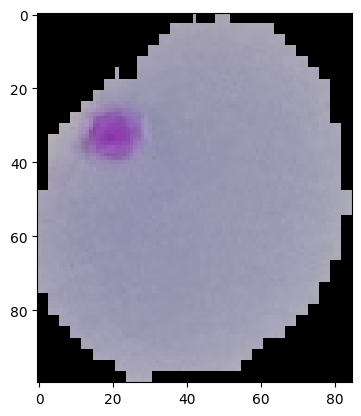

In [12]:
plt.imshow(para_img)

In [13]:
# Checking the image dimensions
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

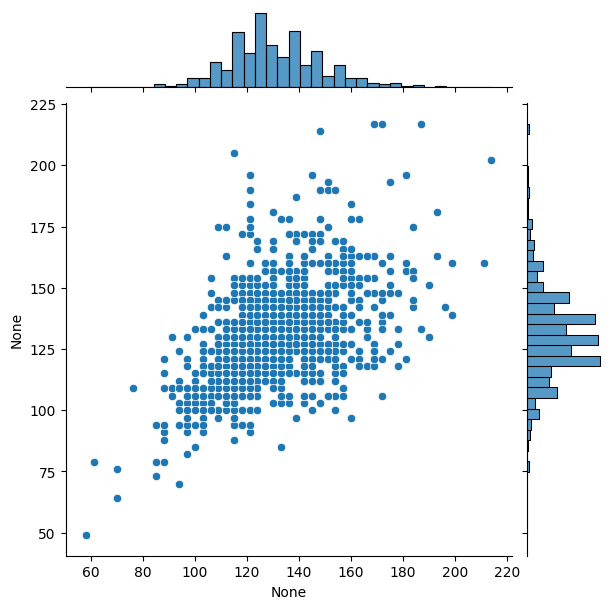

In [14]:
sns.jointplot(x=dim1,y=dim2)

In [15]:
image_shape = (130,130,3)

In [16]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [17]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [18]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [19]:
model = models.Sequential()
model.add(keras.Input(shape=(image_shape)))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(128))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

batch_size = 16

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

2023-11-09 14:57:22.981898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 14:57:22.982142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 14:57:22.982246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [20]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [21]:
train_image_gen.batch_size

16

In [22]:
len(train_image_gen.classes)

24958

In [23]:
train_image_gen.total_batches_seen

0

In [24]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [25]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [26]:
results = model.fit(train_image_gen,epochs=8,
                              validation_data=test_image_gen
                             )

Epoch 1/8


2023-11-09 14:57:59.882926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-11-09 14:58:00.124010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-09 14:58:00.175123: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7ee9498370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-09 14:58:00.175156: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GRID A100D-80C, Compute Capability 8.0
2023-11-09 14:58:00.180994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-09 14:58:00.322293: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1560/1560 [==============================] - 109s 68ms/step - loss: 0.2924 - accuracy: 0.8951 - val_loss: 0.1844 - val_accuracy: 0.9419
Epoch 2/8
1560/1560 [==============================] - 107s 68ms/step - loss: 0.1792 - accuracy: 0.9460 - val_loss: 0.1964 - val_accuracy: 0.9296
Epoch 3/8
1560/1560 [==============================] - 106s 68ms/step - loss: 0.1761 - accuracy: 0.9469 - val_loss: 0.1990 - val_accuracy: 0.9185
Epoch 4/8
1560/1560 [==============================] - 106s 68ms/step - loss: 0.1745 - accuracy: 0.9457 - val_loss: 0.1629 - val_accuracy: 0.9438
Epoch 5/8
1560/1560 [==============================] - 109s 70ms/step - loss: 0.1729 - accuracy: 0.9479 - val_loss: 0.1705 - val_accuracy: 0.9450
Epoch 6/8
1560/1560 [==============================] - 107s 68ms/step - loss: 0.1715 - accuracy: 0.9478 - val_loss: 0.1594 - val_accuracy: 0.9454
Epoch 7/8
1560/1560 [==============================] - 106s 68ms/step - loss: 0.1620 - accuracy: 0.9499 - val_loss: 0.1678 - val_accur

In [27]:
model.save('cell_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
losses = pd.DataFrame(model.history.history)

<Axes: >

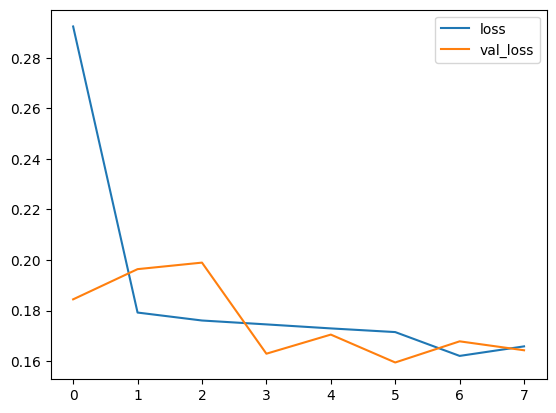

In [29]:
losses[['loss','val_loss']].plot()

In [30]:
model.metrics_names

['loss', 'accuracy']

In [31]:
model.evaluate(test_image_gen)

163/163 [==============================] - 10s 61ms/step - loss: 0.1633 - accuracy: 0.9477


[0.16326965391635895, 0.947692334651947]

In [32]:
pred_probabilities = model.predict(test_image_gen)

163/163 [==============================] - 10s 62ms/step


In [33]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [34]:
predictions = pred_probabilities > 0.5

In [35]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1300
           1       0.93      0.97      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [36]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1206,   94],
       [  42, 1258]])

In [39]:
import random as rnd

1/1 [==============================] - 0s 114ms/step


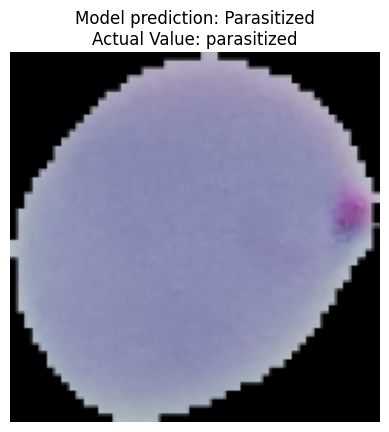

In [40]:
list_dir=["Un Infected","parasitized"]
dir_=(rnd.choice(list_dir))
p_img=imread(train_path+'/'+dir_+'/'+os.listdir(train_path+'/'+dir_)[rnd.randint(0,100)])
img  = tf.convert_to_tensor(np.asarray(p_img))
img = tf.image.resize(img,(130,130))
img=img.numpy()
pred=bool(model.predict(img.reshape(1,130,130,3))<0.5 )
plt.title("Model prediction: "+("Parasitized" if pred  else "Un Infected")+"\nActual Value: "+str(dir_))
plt.axis("off")
plt.imshow(img)
plt.show()